
<H1 style="text-align: center">ECMM426 - Computer Vision</H1>
<H1 style="text-align: center">Workshop 4</H1>
<H1 style="text-align: center">Bag of Visual Words</H1>


In Computer Vision, before the deel learning era, Bag of visual words (BOVW) was a commonly used framework for image classification, object detection and many other tasks. The concept of BOVW is adapted from information retrieval and the bag of words (BOW) concept of Natural Language Processing.

The general idea of BOVW is to represent an image as a set of features. Features consists of keypoints and descriptors. Keypoints are the “stand out” points in an image, so no matter the image is rotated, shrink, or expand, its keypoints will always be the same. And descriptor is the description of the keypoint. We use the keypoints and descriptors to construct vocabularies and represent each image as a frequency histogram of features that are in the image. From the frequency histogram, later, we can find another similar images or predict the category of the image. In this workshop, we are expected to develop an image classifier based on BOVW model using Python.

<img src="https://www.robots.ox.ac.uk/~vgg/research/encoding_eval/images/flow_web.png" alt="bag of visual words framework" width="950"/>

An example of a typical bag of words classification pipeline. Figure by [Chatfield et al.](https://www.robots.ox.ac.uk/~vgg/research/encoding_eval/)

In [41]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

# opencv contrib version is needed because of sift (issues related to patent)
!pip3 install opencv-contrib-python==4.7.0.68
import cv2

## Dataset
We are given a dataset which contains variable number of instances per class, there are 7 classes: City, Face, Greenery, Building, House Indoor, Office, Sea. The dataset is also divided into two as training and test. We are expected to train our classifier using the training image set and test it using the test image set.

In [42]:
if not os.path.exists('bovw7.zip'):
    !wget --no-check-certificate https://empslocal.ex.ac.uk/people/staff/ad735/ECMM426/bovw7.zip
    !unzip -q bovw7.zip

## Utils
Below you find some utility functions that we will be using while implementing our BOVW framework for image classification. The main purposes of these functions are written as comments above the functions.

In [43]:
# Return the image files
def getFiles(path, shuffle=False):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))
    if shuffle:
        np.random.shuffle(images)
    return images

# Return the train and test splits of bovw data
def getSplits(path):
    train_images = getFiles(os.path.join(path, 'train'), True)
    test_images = getFiles(os.path.join(path, 'test'), False)
    train_classes = np.unique([tr_im.split('/')[2] for tr_im in train_images], return_inverse=True)[1]
    test_classes = np.unique([te_im.split('/')[2] for te_im in test_images], return_inverse=True)[1]
    return train_images, train_classes, test_images, test_classes

# Compute image descriptors
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

# Read image
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

# Gather the image descriptors
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

# Cluster the image descriptors
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

# Compute BOVW features for image
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

# Normalize the image features
def normalizeFeatures(scale, features):
    return scale.transform(features)

# Plot histogram
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

# Parameter selection of SVM
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

# Train SVM
def trainSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

# Plot confusion matrix
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Just wrap up the above function
def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", 
                   "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

# Compute accuracy
def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

## Training

The training of the BOVW image classification task is implemented in the below function. Different steps are annotated as comments.

In [44]:
def trainModel(path, no_descriptors_kmeans, no_clusters, kernel):
    train_images, train_classes = getSplits(path)[:2]
    # Step 1: Feature Extraction
    sift = cv2.SIFT_create()
    print("Train: Images path detected.")

    descriptor_list = []
    for img_path in train_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Train: Descriptors vstacked.")

    # Step 2: Encoding or Clustering
    random_indices = np.random.choice(descriptors.shape[0], size=no_descriptors_kmeans, replace=False)
    descriptors_kmeans = descriptors[random_indices, :]
    # vocabulary creation
    kmeans = clusterDescriptors(descriptors_kmeans, no_clusters)
    print("Train: Descriptors clustered.")

    # Step 3: Pooling or Quantization
    # feature quantization and histogram computation
    im_features = extractFeatures(kmeans, descriptor_list, len(train_images), no_clusters)
    print("Train: Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train: Image features normalized.")

    # Step 4: Classification
    plotHistogram(im_features, no_clusters)
    print("Train: Histogram features plotted.")

    svm = trainSVM(im_features, train_classes, kernel)
    print("Train: SVM fitted.")
    print("Train: Process completed.")

    return kmeans, scale, svm, im_features

## Test

The test phase of the BOVW image classification task is implemented in the below function. Different steps are annotated as comments.

In [45]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images, test_classes = getSplits(path)[2:]
    print("Test: Images path detected.")
    count = 0
    descriptor_list = []
    valid_idx = []
    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }
    # Step 1: Feature Extraction
    sift = cv2.SIFT_create()

    for i, img_path in enumerate(test_images):
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if des is not None:
            count += 1
            descriptor_list.append(des)
            valid_idx.append(i)

    # remove the images that have zero descriptors
    test_classes = test_classes[valid_idx]

    descriptors = vstackDescriptors(descriptor_list)
    print("Test: Descriptors vstacked.")

    # Step 3: Pooling or Quantization
    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)
    print("Test: Images features extracted.")

    test_features = scale.transform(test_features)
    print("Test: Image features normalized.")

    # Step 4. Classification
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)

    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    true = [name_dict[str(int(i))] for i in test_classes]
    print("Test: Images classified.")

    plotConfusions(true, predictions)
    print("Test: Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Test: Accuracy calculated.")
    print("Test: Execution done.")

## Execution

The cell below will set the parameters and execute the model.

Train: Images path detected.
Train: Descriptors vstacked.
Train: Descriptors clustered.
Train: Images features extracted.
Train: Image features normalized.


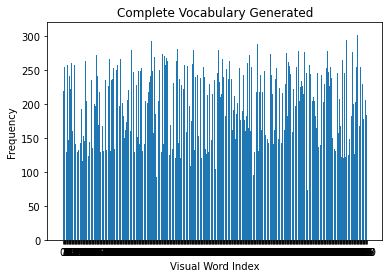

Train: Histogram features plotted.
0.1 0.1
Train: SVM fitted.
Train: Process completed.
Test: Images path detected.
Test: Descriptors vstacked.
Test: Images features extracted.
Test: Image features normalized.
Test: Images classified.
Confusion matrix, without normalization
[[24  0  3  0  0  0  3]
 [ 0 26  2  0  0  0  2]
 [ 6  5 17  0  0  0  2]
 [ 3  1  1 16  1  8  0]
 [ 3  1  1  2  4 19  0]
 [ 2  0  1  2  0 25  0]
 [ 1  1  7  0  0  0 20]]
Normalized confusion matrix
[[0.8  0.   0.1  0.   0.   0.   0.1 ]
 [0.   0.87 0.07 0.   0.   0.   0.07]
 [0.2  0.17 0.57 0.   0.   0.   0.07]
 [0.1  0.03 0.03 0.53 0.03 0.27 0.  ]
 [0.1  0.03 0.03 0.07 0.13 0.63 0.  ]
 [0.07 0.   0.03 0.07 0.   0.83 0.  ]
 [0.03 0.03 0.24 0.   0.   0.   0.69]]


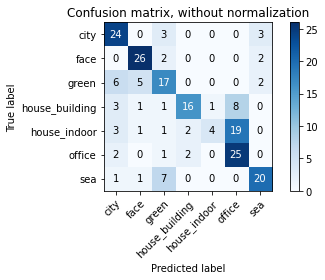

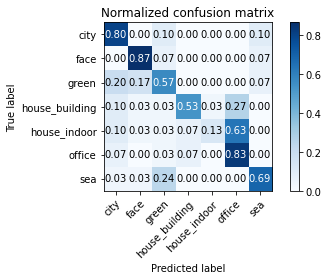

Test: Confusion matrixes plotted.
accuracy score: 0.632
Test: Accuracy calculated.
Test: Execution done.


In [46]:
# Set some important parameters
path = 'bovw7'
no_clusters = 500
no_descriptors_kmeans = 20000
kernel = 'linear'
# Training step
kmeans, scale, svm, im_features = trainModel(path, no_descriptors_kmeans, no_clusters, kernel)
# Test step
testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel)

This simple pipeline approximately obtains 60% accuracy on the dataset, which is better than the random performance which should be around 14%.